# TODO

- Documentation
- Remove the 3 parameter references in the utility functions


# COVID-19 Data Visualization & Exploration

Visualize the distribution of cases, the growth rate across countries and the behaviour in different states across India

# Data Source
World Data - Johns Hopkins University <br>
India Data: covid19india.org

World: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
 - time_series_covid19_confirmed_global_iso3_regions.csv
 - time_series_covid19_deaths_global_iso3_regions.csv
 - time_series_covid19_recovered_global_iso3_regions.csv
 
India: http://api.covid19india.org

# Imports & Initialization

In [1]:
import pandas as pd
import os
from functools import reduce
import operator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

base_input_dir = 'input/2Jan2020'
base_output_dir = 'output'
state_code_population_mapper_file = 'input/StateCodePopulationFile.csv'

world_confirmed_file = 'time_series_covid19_confirmed_global_iso3_regions.csv'
world_recovered_file = 'time_series_covid19_recovered_global_iso3_regions.csv'
world_death_file = 'time_series_covid19_deaths_global_iso3_regions.csv'

india_confirmed_file = 'confirmed.csv'
india_recovered_file = 'recovered.csv'
india_death_file = 'deceased.csv'


# Utility Functions


## Read input csv file

In [3]:
# Ensure "NA" in data is not read as NaN by Python
# Function reads the first 25 lines of the file and identifies if a column is of type string or numeric
# NA values are replaced with NaN only for numeric columns
def conversion_na_values(abs_filename, nrows=25, sep=';', read_as='csv', na_values=None):
    if na_values is None:
        na_values = ["", ".", "-", "NA"]
    if read_as == 'csv':
        tmp_df = pd.read_csv(abs_filename, nrows=nrows, sep=sep, float_precision='round_trip', na_values=na_values)
    elif read_as == 'xls':
        tmp_df = pd.read_excel(abs_filename, nrows=nrows, na_values=na_values)

    na_values_cols = {}
    for col in tmp_df.columns:
        na_values_cols[col] = [''] if tmp_df[col].dtype == 'object' else na_values

    return na_values_cols

def read_data(filepath, sep=','): 
    na_values_cols = conversion_na_values(filepath, sep=',') 
    return pd.read_csv(filepath, sep=sep, index_col=False, na_values=na_values_cols,  float_precision='round_trip')

## Read the world data file to dataframes 
Dataframes Returned: 
- complete original data, 
- total cases per country
- daily reported cases by date

In [4]:
def parse_world_CRD_file(world_filename,file_prefix):
        
    world_orig = read_data(os.path.join(base_input_dir,world_filename), sep=',')
    print(f'Parsing file:{world_filename}')
    print(f'Shape:{world_orig.shape}')
    
    #Delete 1st row
    world_orig = world_orig[1:]

    # Roll-up on country-region
    drop_columns_for_country_rollup = ['Province/State','Lat','Long','ISO 3166-1 Alpha 3-Codes',
           'Region Code', 'Region Name', 'Sub-region Code', 'Sub-region Name',
           'Intermediate Region Code', 'Intermediate Region Name']
    world_byCountry = world_orig.drop(drop_columns_for_country_rollup, axis=1)
    world_byCountry=world_byCountry.groupby(["Country/Region"],as_index=False).sum()
    
    # Transpose to get world_byDate
    world_byDate = world_byCountry.set_index('Country/Region').T
    world_byDate = world_byDate.reset_index().rename(columns={'index':'Date'})

    # Find total_ and daily_ for world_byDate
    world_byDate[f'Total_{file_prefix}'] = world_byDate.iloc[:,1:].sum(axis=1)
    world_byDate[f'Daily_{file_prefix}'] = world_byDate[f'Total_{file_prefix}'].diff(periods=1)

    # Find total_ for world_byCountry
    last_date_column_name = world_byCountry.columns[-1]
    world_byCountry[f'Total_{file_prefix}'] = world_byCountry.iloc[:,-1]


    # Find total_ for world_orig
    world_orig[f'Total_{file_prefix}'] = world_orig[last_date_column_name]
    
    return world_orig,world_byCountry,world_byDate

In [5]:
## Function to create a subset of a dataframe based on the given condition

In [6]:
def subset_on_condition(input_df, parameters):
    condition = parameters.get("condition", '>=')
    operators = {'>': operator.gt,
                 '<': operator.lt,
                 '>=': operator.ge,
                 '<=': operator.le,
                 '=': operator.eq,
                 '!=': operator.ne}

    if condition not in operators:
        raise Exception(f'Condition operator not supported:{condition}')

    condition_op = operators[condition]
    final_df = pd.DataFrame()
    for column_name in input_df.columns:
        column_df = pd.DataFrame(input_df[column_name][condition_op(input_df[column_name], parameters["value"])])
        column_df.reset_index(drop=True, inplace=True)
        final_df = pd.concat([final_df, column_df], ignore_index=True, axis=1)

    final_df.columns = input_df.columns
    # Add index column if required
    if "index_column_name" in parameters:
        final_df.insert(loc=0, column=parameters["index_column_name"], value=np.arange(1, len(final_df) + 1))
    return final_df


# Read the data

## Parse the world input files and get the dataframes for the cases ordered by country and ordered by Date

In [7]:
confirmed_orig,confirmed_byCountry,confirmed_byDate = parse_world_CRD_file(world_filename=world_confirmed_file,file_prefix = 'confirmed')
recovered_orig,recovered_byCountry,recovered_byDate = parse_world_CRD_file(world_filename=world_recovered_file,file_prefix = 'recovered')
death_orig,death_byCountry,death_byDate = parse_world_CRD_file(world_filename=world_death_file,file_prefix = 'death')

Parsing file:time_series_covid19_confirmed_global_iso3_regions.csv
Shape:(272, 357)
Parsing file:time_series_covid19_recovered_global_iso3_regions.csv
Shape:(257, 357)
Parsing file:time_series_covid19_deaths_global_iso3_regions.csv
Shape:(272, 357)


# Data Preprocessing

## Create world_CRD_byDate by joining the data from confirmed, recovered & death dataframes
CRD - Confirmed, Recovered, Death/Deceased

In [8]:
# Merge confirmed & recovered cases
world_CR_byDate =  pd.merge(confirmed_byDate[['Date','Total_confirmed','Daily_confirmed']],recovered_byDate[['Date','Total_recovered','Daily_recovered']],how='outer',on=['Date'])
# Merge result with death cases
world_CRD_byDate =  pd.merge(world_CR_byDate[['Date','Total_confirmed','Daily_confirmed','Total_recovered','Daily_recovered']],death_byDate[['Date','Total_death','Daily_death']],how='outer',on=['Date'])

# write_csv_output(df=world_CRD_byDate, filename='world_CRD_byDate')

## Create world_CRD_byCountry by joining the data from confirmed, recovered & death dataframes

In [9]:
# Create world_CRD_byCountry with full outer join
world_CR_byCountry =  pd.merge(confirmed_byCountry[['Country/Region','Total_confirmed']],recovered_byCountry[['Country/Region','Total_recovered']],how='outer',on=['Country/Region'])
world_CRD_byCountry =  pd.merge(world_CR_byCountry[['Country/Region','Total_confirmed','Total_recovered']],death_byCountry[['Country/Region','Total_death']],how='outer',on=['Country/Region'])

#write_csv_output(df=world_CRD_byCountry, filename='world_CRD_byCountry')

## Create Day_N dataframe which contains the data for the top few countries to be compared

In [10]:

# Find top 10 countries
sorted_byCountry = world_CRD_byCountry.sort_values(by=['Total_confirmed'], ascending=False)['Country/Region'].head(10).tolist()
# Add custom list of countries
#sorted_byCountry.extend(['India','China','Japan','Korea, South'])
sorted_byCountry = list(set(sorted_byCountry))
dayN_df = subset_on_condition(confirmed_byDate[confirmed_byDate.columns & sorted_byCountry],{"index_column_name":"Day","value":1})
dayN_df['Day_N'] = 'Day_' + dayN_df['Day'].astype(str)


#write_csv_output(df=dayN_df, filename='dayN')

## Create Mapping of sub-region name to continent name and continent code

In [11]:

data = [['Northern Africa', 'Africa', 'AF'], ['Sub-Saharan Africa', 'Africa', 'AF'],
        ['Latin America and the Caribbean', 'South America', 'SA'], ['Northern America', 'North America', 'NA'],
        ['Central Asia', 'Asia', 'AS'], ['Eastern Asia', 'Asia', 'AS'], ['South-eastern Asia', 'Asia', 'AS'],
        ['Southern Asia', 'Asia', 'AS'], ['Western Asia', 'Asia', 'AS'], ['Eastern Europe', 'Europe', 'EU'],
        ['Northern Europe', 'Europe', 'EU'], ['Southern Europe', 'Europe', 'EU'], ['Western Europe', 'Europe', 'EU'],
        ['Australia and New Zealand', 'Australia', 'AU'], ['Melanesia', 'Australia', 'AU'],
        ['Polynesia', 'Australia', 'AU']]
subregion_continent_map = pd.DataFrame(data, columns=['Sub-region Name', 'Continent_Name', 'Continent_code'])

## World Map - Region, Subregion count

In [12]:
world_region_subregion = confirmed_orig[["Region Name","Sub-region Name","Total_confirmed"]].groupby(["Region Name","Sub-region Name"],as_index=False).sum()
world_subregion_count =  pd.merge(world_region_subregion,subregion_continent_map,how='inner',on=['Sub-region Name'])
world_subregion_count.sort_values(by=['Total_confirmed'], ascending=False,inplace=True)

# write_csv_output(df=world_subregion_count, filename='world_subregion_count')
print(world_subregion_count)

   Region Name                  Sub-region Name  Total_confirmed  \
3     Americas                 Northern America       20714727.0   
2     Americas  Latin America and the Caribbean       15687368.0   
7         Asia                    Southern Asia       12887894.0   
9       Europe                   Eastern Europe        7978619.0   
12      Europe                   Western Europe        6716817.0   
11      Europe                  Southern Europe        5673657.0   
8         Asia                     Western Asia        5597315.0   
10      Europe                  Northern Europe        3548836.0   
1       Africa               Sub-Saharan Africa        1855676.0   
6         Asia               South-eastern Asia        1535313.0   
0       Africa                  Northern Africa         944955.0   
5         Asia                     Eastern Asia         399728.0   
4         Asia                     Central Asia         373694.0   
13     Oceania        Australia and New Zealand 

## World Map

In [13]:
continent_count = world_subregion_count[["Continent_Name","Continent_code","Total_confirmed"]].groupby(["Continent_Name","Continent_code"],as_index=False).sum()
#continent_count.sort_values(by=['Total_confirmed'], ascending=False,inplace=True)
continent_count.sort_values(by=['Continent_Name'], ascending=False,inplace=True)
print(continent_count)

  Continent_Name Continent_code  Total_confirmed
5  South America             SA       15687368.0
4  North America             NA       20714727.0
3         Europe             EU       23917929.0
2      Australia             AU          48435.0
1           Asia             AS       20793944.0
0         Africa             AF        2800631.0


# Data Visualization

## Global view - spread of cases across continents

In [14]:
# world map

In [15]:
# pie chart

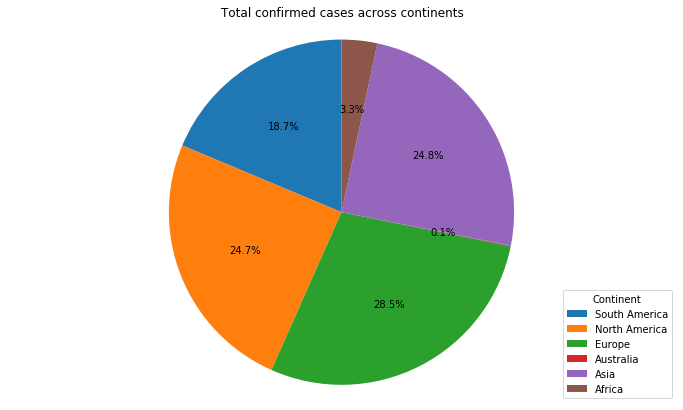

In [16]:
f, ax = plt.subplots(figsize=(12,7))
plt.pie(continent_count['Total_confirmed'],  startangle=90, autopct='%1.1f%%')
plt.legend(continent_count['Continent_Name'], loc="lower right", title = 'Continent')

plt.axis('equal')
plt.title('Total confirmed cases across continents')

plt.show()

- Europe has the most number of confirmed cases with 28.5% of the total cases reported globally 
- Australia looks to be the safest place currently with 0.1% of the total reported cases 

In [17]:
# funnel chart?

## HEAT MAP?

## Sub-region wise distribution of cases

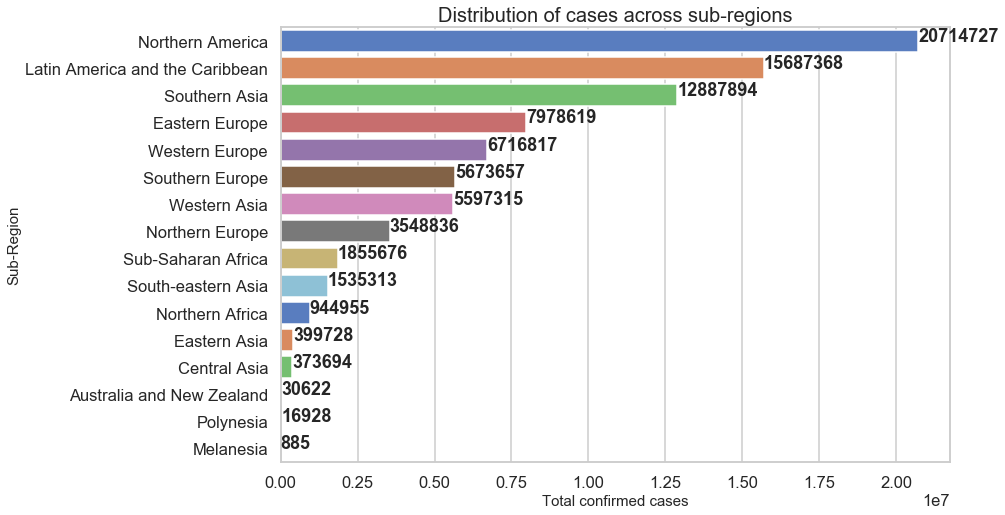

In [24]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(y='Sub-region Name', x='Total_confirmed', data=world_subregion_count, ci=None, palette="muted",orient='h' )
ax.set_title("Distribution of cases across sub-regions", fontsize=20)
ax.set_xlabel ("Total confirmed cases", fontsize=15)
ax.set_ylabel ("Sub-Region", fontsize=15)
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.0f"% rect.get_width(), weight='bold' )
plt.show()

- North America has the maximum no. of reported cases followed by Latin America
- Regions in Australia have the least no. of reported cases with Melanesia reporting the least no. of cases

## Comparison of growth across countries based on the days since the first reported case

### Plot a multiseries line chart

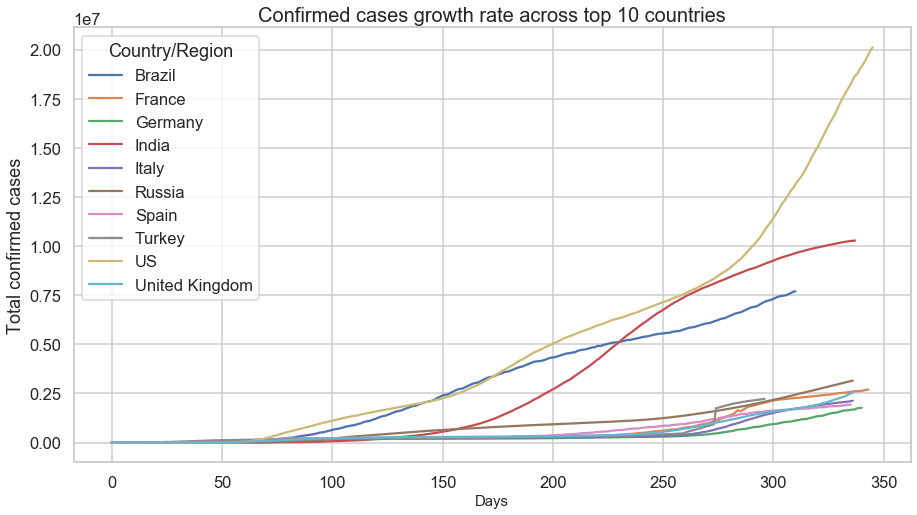

In [26]:
#sns.lineplot(data=dayN_df.iloc[:, 1:11],dashes = False)
#sns.lineplot(x='Year', y='value', hue='variable', data=pd.melt(data_preproc, ['Year']))

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(15,8))
ax = sns.lineplot(data=dayN_df.iloc[:, 1:11],dashes = False)
ax.set_title("Confirmed cases growth rate across top 10 countries", fontsize=20)
ax.set_xlabel ("Days", fontsize=15)
ax.set_ylabel ("Total confirmed cases")
plt.show()

- The top 10 countries with the maximum no. of cases are considered in this chart
- Chart shows the total no. of cases reported starting from the first day of reported cases in that country
- USA has the steepest growth rate & the maximum no. of cases reported followed by India

## World-wide growth of total confirmed cases

In [20]:
# Multiseries line chart

In [21]:
# World wide growth of daily confirmed cases

## Last one week trend - CRD

### Extract last 7 days data and get the no. of confirmed, recovered and death cases for each day

In [22]:
last7days = world_CRD_byDate.tail(7)[['Date','Daily_confirmed','Daily_recovered','Daily_death']]
last7days.rename(columns = {'Daily_confirmed':'Confirmed','Daily_recovered':'Recovered','Daily_death':'Death'}, inplace = True)
last7daysCRD = last7days.melt('Date', var_name='CRD', value_name='Total_cases')

### Plot a grouped bar chart

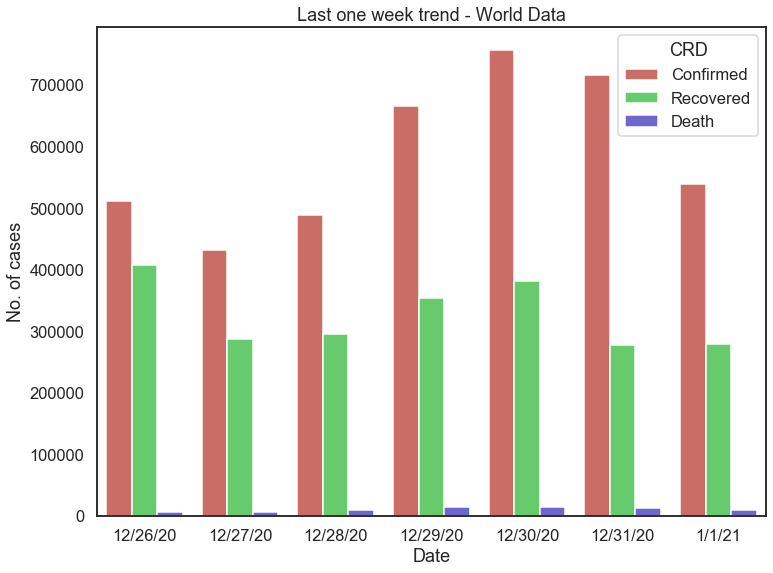

In [23]:
sns.set(style="white", context="talk")
f, ax = plt.subplots(figsize=(12,9))
ax = sns.barplot(x=last7daysCRD['Date'],y=last7daysCRD['Total_cases'],hue=last7daysCRD['CRD'], palette = 'hls') 
ax.set(xlabel='Date', ylabel='No. of cases')
plt.title("Last one week trend - World Data")
plt.show()

## Time taken for cases to double